In [16]:
import datafold
import sklearn
import numpy as np
import pickle
import os
import platform
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from PCA_own_implementation import PCA_custom
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA, SparsePCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler

In [17]:
#A method to represent dataset, returning the transformed dataset, the pca and its variance to see how much information we loose
#by reducing the number of dimensions
def PCA_representation(dataset,n_components, type = "std") :
    t_beg = time.time()
    if type == "std" :
        pca = PCA(n_components)
    if type == "full" :
        pca = PCA(n_components, svd_solver = 'full')
    elif type == "incremental" :
        pca = IncrementalPCA(n_components, batch_size = 700)
    elif type == "randomized" :
        pca = PCA(n_components, svd_solver='randomized')
    elif type == "truncated" :
        pca = TruncatedSVD(n_components, n_iter=10)
    elif type == "custom" :
        pca = PCA_custom(n_components)
    if type == "incremental" :
        x_transformed = pca.partial_fit(dataset)
    else :
        x_transformed = pca.fit(dataset)
    if type!="sparse" :
        var_explained = np.sum(pca.explained_variance_ratio_)
        print("Total variance kept in the decomposition : ",np.sum(pca.explained_variance_ratio_))
    if type=="std" or type=="custom" : 
        print("Number components : ",pca.n_components_)
    t = time.time() - t_beg
    print("time taken to fit the pca : ",t)
    return pca

#Method that transforms the dataset thanks to a pca that has already been fitted. Then it inverse the transform
def reconstructed(dataset,pca) :
    data_tr = pca.transform(pca)
    data_retr = pca.inverse_transform(data_tr)
    return data_retr
    

#Measure of how well the decomposition is representing the original set
def pca_behaviour(dataset) :
    len = dataset.shape[0]
    t = []
    n_comp = []
    n_samples = []
    for i in range(int(len/10),len+1,int(len/10)) :
        t_beg = time.time()
        pca = PCA_representation(dataset[:i], 0.99)
        t.append(time.time() - t_beg)
        n_comp.append(pca.n_components_)
        n_samples.append(i)
    plt.plot(n_samples, t)
    plt.show()
    plt.plot(n_samples, n_comp)
    plt.show()
    
#Method ploting the variance explained ratio depending on the number of remaining components   
def variance_per_comp(pca) :
    var_explained = []
    comp = []
    for i in range(1,300,10) :
        var_explained.append(np.sum(pca.explained_variance_ratio_[:i]))
        comp.append(i)
    plt.xlabel("Number of Components kept")
    plt.ylabel("Cumulative explained variance")
    plt.title("Explained variance when varying the number of components")
    plt.plot(comp, var_explained)
    plt.show()
    
#Preprocessing method
def scalling_data(dataset) :
    scaler_train = StandardScaler()
    scaler_train.fit(dataset)
    return scaler_train.transform(dataset) 

# CIFAR-10

In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=45000, num_validation=5000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = "cifar-10-batches-py/"
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    x_train = X_train.astype('float32')
    x_test = X_test.astype('float32')

    x_train /= 255
    x_test /= 255

    return x_train, y_train, X_val, y_val, x_test, y_test

In [4]:
# Invoke the above function to get our data.
x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data()

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (45000, 3072)
Train labels shape:  (45000,)
Validation data shape:  (5000, 3072)
Validation labels shape:  (5000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


In [5]:
#Building different sets
small_vector = x_train[:10000]
train_rescale = scalling_data(x_train)


c = 0
for i in range(x_train.shape[0]) :   
    if y_train[i] == 1 :        
        c+=1
cars = np.zeros((c,3072))
s=0
for i in range(x_train.shape[0]) :   
    if y_train[i] == 1 :        
        cars[s]=x_train[i]
        s+=1


# Decompositions

In [6]:
pca_CIFAR = PCA_representation(x_train, 0.99, type='std')

Total variance kept in the decomposition :  0.990009
Number components :  657
time taken to fit the pca :  29.9082772731781


In [7]:
pca_CIFAR_random = PCA_representation(x_train, 216, type='randomized')

Total variance kept in the decomposition :  0.98987424
Number components :  657
time taken to fit the pca :  14.292680978775024


In [8]:
pca_CIFAR_random = PCA_representation(x_train, 216, type='std')

Total variance kept in the decomposition :  0.9499431
Number components :  216
time taken to fit the pca :  8.733412027359009


In [33]:
#Comparing the Randomized PCA with a standard PCA, that compute the entire singular values decomposition
pca_CIFAR_custom = PCA_representation(small_vector, 600, type='custom')
pca_CIFAR_custom = PCA_representation(small_vector, 600, type='std')

Total variance kept in the decomposition :  0.9891708524412348
Number components :  600
time taken to fit the pca :  56.24299740791321
Total variance kept in the decomposition :  0.98902476
Number components :  600
time taken to fit the pca :  4.769899845123291


In [36]:
#Comparing the Randomized PCA with a standard PCA, that compute the entire singular values decomposition
pca_CIFAR_custom = PCA_representation(x_train, 600, type='randomized')
pca_CIFAR_custom = PCA_representation(x_train, 600, type='full')

Total variance kept in the decomposition :  0.9879265
time taken to fit the pca :  12.670191287994385
Total variance kept in the decomposition :  0.9880858
Number components :  600
time taken to fit the pca :  34.36265254020691


In [8]:
pca_CIFAR = PCA_representation(train_rescale, 0.99)

Total variance kept in the decomposition :  0.99001
Number components :  661
time taken to fit the pca :  33.716124057769775


In [9]:
pca_CIFAR_ex = PCA_representation(small_vector, 657, False)

UnboundLocalError: local variable 'pca' referenced before assignment

In [ ]:
pca_CIFAR_ex = PCA_representation(small_vector, 657)

# Analysis

In [10]:
pca_behaviour(x_train)
variance_per_comp(pca_CIFAR)

Total variance kept in the decomposition :  0.99002194
Number components :  588
time taken to fit the pca :  11.032191753387451
Total variance kept in the decomposition :  0.9900241
Number components :  621
time taken to fit the pca :  11.396819114685059
Total variance kept in the decomposition :  0.990002
Number components :  635
time taken to fit the pca :  13.180166244506836
Total variance kept in the decomposition :  0.99001884
Number components :  644
time taken to fit the pca :  15.86076283454895
Total variance kept in the decomposition :  0.9900113
Number components :  647
time taken to fit the pca :  17.54460644721985
Total variance kept in the decomposition :  0.9900211
Number components :  651
time taken to fit the pca :  19.209998846054077
Total variance kept in the decomposition :  0.9900134
Number components :  653
time taken to fit the pca :  23.50054931640625
Total variance kept in the decomposition :  0.9900295
Number components :  655
time taken to fit the pca :  24.58

KeyboardInterrupt: 

In [ ]:
pca_9 = PCA_representation(x_train, 0.9)

In [ ]:
pca_9 = PCA_representation(x_train, 0.9)
x_reduced_9 = pca_9.transform(x_train)
x_reconstructed_9 = pca_9.inverse_transform(x_reduced_9)

In [ ]:
pca_95 = PCA_representation(x_train, 0.95)
x_reduced_95 = pca_95.transform(x_train)
x_reconstructed_95 = pca_95.inverse_transform(x_reduced_95)

In [ ]:
#Displaying a picture from the CIFAR-10 dataset
def display(array) :
    single_img = np.array(array)
    single_img_reshaped = np.transpose(np.reshape(single_img,(3, 32,32)), (1,2,0))
    plt.imshow(single_img_reshaped)
    plt.show()

In [ ]:
print(cars.shape)
display(cars[0])

In [ ]:
pca_cars = PCA_representation(cars, 0.99)

In [ ]:
comp = np.zeros((1,pca_cars.n_components_))
cars_tr = pca_cars.transform(cars)
print(cars_tr.shape)
comp[0][1] = 1
car_reconstructed = pca_cars.inverse_transform(comp)
print(car_reconstructed.shape)

In [ ]:
display(car_reconstructed[0])

In [ ]:
#Displaying a picture

In [ ]:
#Displaying a picture from the CIFAR-10 dataset
def display(array) :
    single_img = np.array(array)
    single_img_reshaped = np.transpose(np.reshape(single_img,(3, 32,32)), (1,2,0))
    plt.imshow(single_img_reshaped)
    plt.show()

In [ ]:
#Comparing the original image and the reconstructed one
display(x_train[0])
display(x_reconstructed[0])

In [ ]:
#plotting several samples to check if the visualization is still good
for i in range(5) :
    display(x_reconstructed_95[i])

# Google2Vec

In [11]:
import gensim

In [12]:
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)  

In [ ]:
vectors = model.vectors
print(vectors.shape)
vocab = model.vocab
print(len(vocab))

In [ ]:
small_vectors = vectors[:1000000]
small_vectors_rescale = scalling_data(small_vectors)
gensim.models.KeyedVectors

In [ ]:
pca = PCA_representation(small_vectors, 200, type='truncated')
pca_tr = PCA_representation(small_vectors_rescale, 200, type='truncated')

In [73]:
pca_std = PCA_representation(small_vectors, 200, type='std')

MemoryError: Unable to allocate 801. MiB for an array with shape (210, 1000000) and data type float32

In [74]:
pca_rd = PCA_representation(small_vectors, 200, type='randomized')

MemoryError: Unable to allocate 1.12 GiB for an array with shape (1000000, 300) and data type float32

In [ ]:
pca_f = PCA_representation(small_vectors, 200, type='full')

In [ ]:
pca = PCA_representation(small_vectors, 0.99, type='std')
pca = PCA_representation(small_vectors_rescale, 0.99, type='std')

In [75]:
#pca = PCA_representation(small_vectors_rescale, 0.99, type='custom')
pca_incr = PCA_representation(small_vectors_rescale, 292, type='incremental')

MemoryError: Unable to allocate 1.12 GiB for an array with shape (1000000, 300) and data type float32

# Analysis

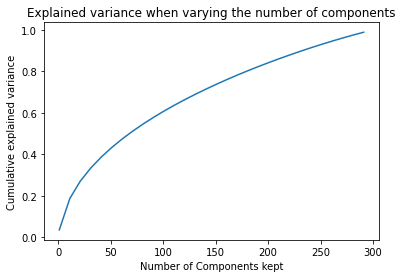

In [43]:
variance_per_comp(pca)

In [ ]:
pcagoogle = PCA_representation(vectors,0.9)

In [13]:
vocab = model.vocab.keys()

In [14]:
print(type(vocab))


<class 'dict_keys'>


In [15]:
wordsInVocab = len(vocab)
print(wordsInVocab)

3000000


In [ ]:
vector_decomp = pca.transform(small_vectors_rescale)

In [32]:
import math
import string

wordsPerFile = int(100E3)
# Load enogugh files to write all our words
files = [open("./vocabulary_%.2d.txt" % n, 'w') for n in range(math.ceil((float(len(vocab)) / float(wordsPerFile))))]
# Filter out unprintable characters
filtered_words =  [''.join(s for s in tmp if s in string.printable) for tmp in vocab]

i = 0
for word in filtered_words:
    print(word, file=files[int(i/wordsPerFile)])
    i+=1
        
for file in files:
    file.close()


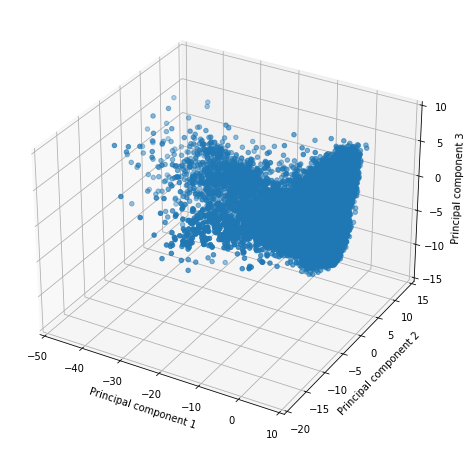

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.scatter(vector_decomp[:100000,0],vector_decomp[:100000,1],vector_decomp[:100000,2])
ax.set_xlabel("Principal component 1")
ax.set_ylabel("Principal component 2")
ax.set_zlabel("Principal component 3")
ax.set_xlim3d(-50, 10)
ax.set_ylim3d(-20, 15)
ax.set_zlim3d(-15, 10)
plt.show()

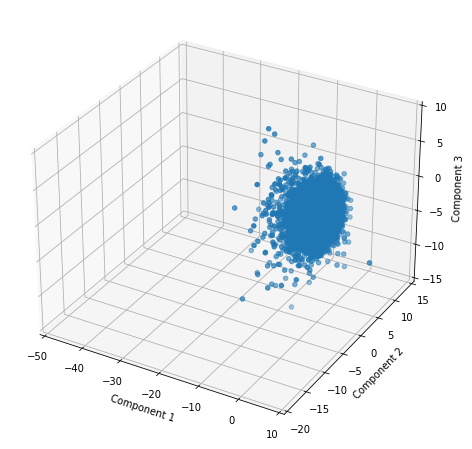

In [67]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.scatter(small_vectors_rescale[:100000,0],small_vectors_rescale[:100000,1],small_vectors_rescale[:100000,2])
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.set_xlim3d(-50, 10)
ax.set_ylim3d(-20, 15)
ax.set_zlim3d(-15, 10)
plt.show()